# I. Importing the required libraries

In [1]:
import os
import random


## Package
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.offline as py
import seaborn as sns

py.init_notebook_mode(connected=True)


## Keras
from keras.callbacks import ModelCheckpoint
from keras.callbacks import  ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import to_categorical


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


## Rest
from scipy import signal
from tqdm import tqdm

input_duration=3

# II. Reading the data

Получение списка фаилов в каталоге данных

In [2]:
# Data Directory
# Please edit according to your directory change.
dir_list = os.listdir('./data')
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


Создаем dataframe data_df в котором указываем информацию о каждом аудиофаиле

In [3]:
# Create DataFrame for Data intel
data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir('./data/' + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = './data/' + i + '/' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])

        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"

        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1

        if nm[4] == '01':
            statement = 0
        else:
            statement = 1

        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1

        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1

In [4]:
print (len(data_df))
data_df.head()

1440


,path,source,actor,gender,intensity,statement,repetition,emotion
0,./data/Actor_01/03-01-01-01-01-01-01.wav,1,1,male,0,0,0,1
1,./data/Actor_01/03-01-01-01-01-02-01.wav,1,1,male,0,0,1,1
2,./data/Actor_01/03-01-01-01-02-01-01.wav,1,1,male,0,1,0,1
3,./data/Actor_01/03-01-01-01-02-02-01.wav,1,1,male,0,1,1,1
4,./data/Actor_01/03-01-02-01-01-01-01.wav,1,1,male,0,0,0,2


# III. Plotting the audio file's waveform and its spectrogram

Выводим информацию о частоте дискретизации и сэмплах

In [5]:
filename = data_df.path[1]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples

./data/Actor_01/03-01-01-01-01-02-01.wav


(22050,
 array([-2.6555711e-06, -1.2237584e-05, -9.1077754e-07, ...,
        -1.0303405e-09,  1.6803573e-09, -2.1517024e-09], dtype=float32))

In [6]:
len(samples), sample_rate

(73574, 22050)

Считаем частоты, временные отметки и логарифмированную спектрограмму


In [7]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)


In [8]:
sample_rate/ len(samples)

0.29969826297333296

Визуализация звукового сигнала и спектрограммы для выбранного аудиофаила

Text(0.5, 0, 'Seconds')

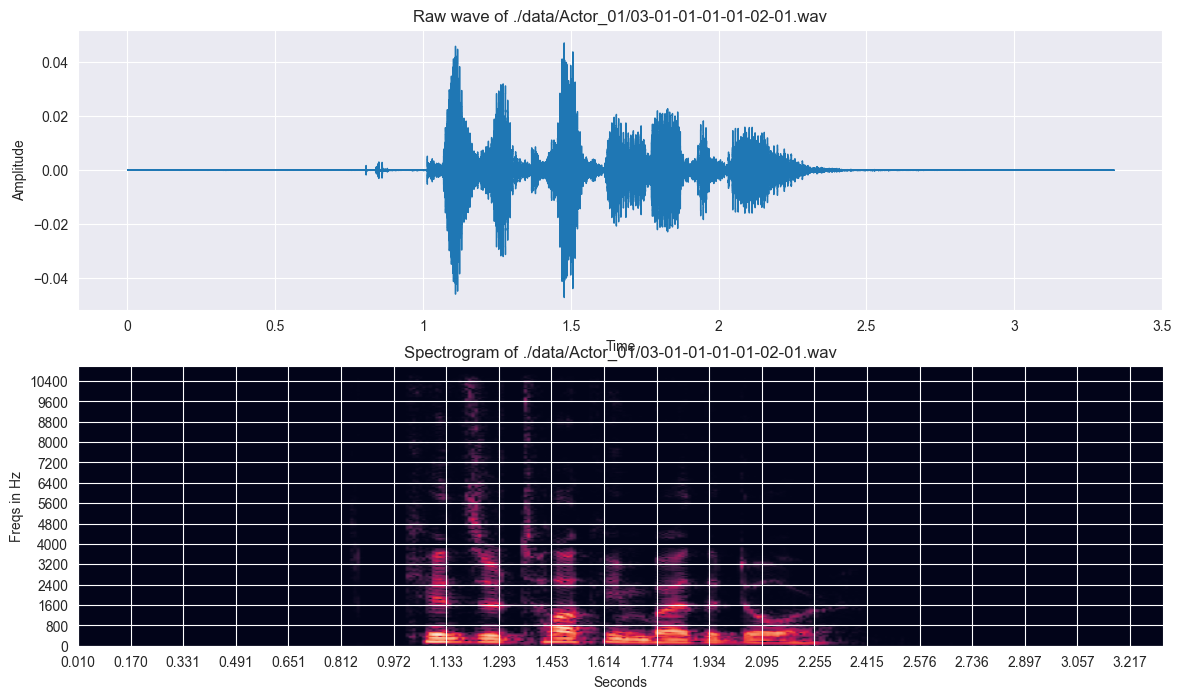

In [9]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveshow(samples, sr=sample_rate, ax=ax1)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower',
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

Z-нормализация спектрограммы

In [10]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

убираем тишину из записи

In [11]:
# Trim the silence voice
aa , bb = librosa.effects.trim(samples, top_db=30)
aa, bb

(array([-2.5486461e-05,  1.4044099e-05,  2.0085568e-05, ...,
         2.3659167e-04,  5.1203166e-04,  6.9050817e-04], dtype=float32),
 array([22016, 51712]))

мел-спектрограмма мощности аудиосигнала

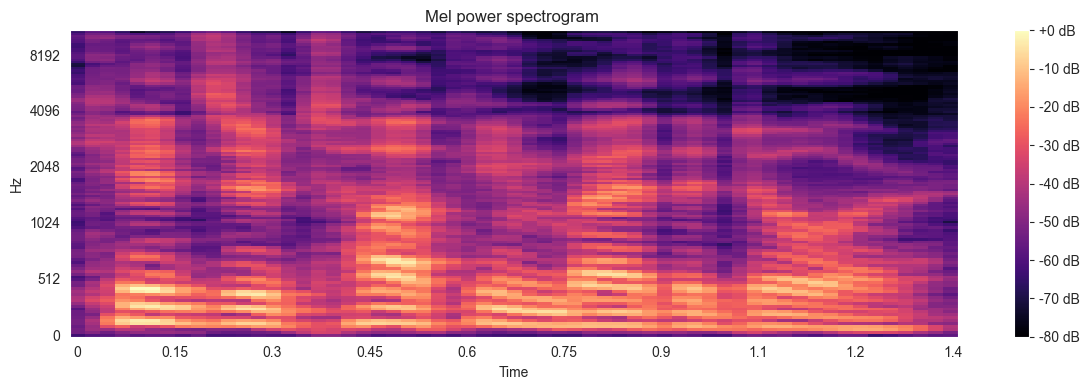

In [12]:
# Plotting Mel Power Spectrogram
S = librosa.feature.melspectrogram(y=aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

визуализация коэффициентов мел-частотных кепстральных коэффициентов (MFCC) для аудиосигнала

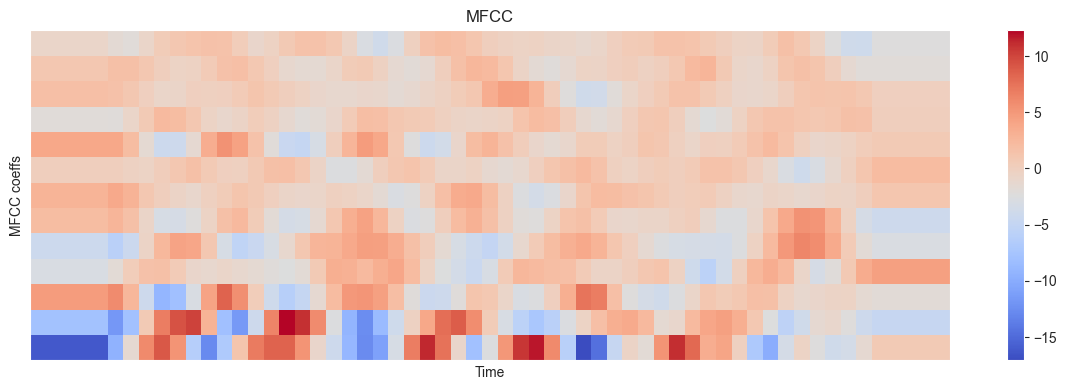

In [13]:
# Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [14]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)

In [15]:
# Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [16]:
# Silence trimmed Sound by manuel trimming
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

# IV. Defining the truth label

In [17]:
# 2 class: Positive & Negative

# Positive: Calm, Happy
# Negative: Angry, Fearful, Sad

label2_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2: # Calm
        lb = "_positive"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"

    # Add gender to the label
    label2_list.append(data_df.gender[i] + lb)

len(label2_list)

1440

In [18]:
#3 class: Positive, Neutral & Negative

# Positive:  Happy
# Negative: Angry, Fearful, Sad
# Neutral: Calm, Neutral

label3_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1: # Neutral
        lb = "_neutral"
    elif data_df.emotion[i] == 2: # Calm
        lb = "_neutral"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"

    # Add gender to the label
    label3_list.append(data_df.gender[i] + lb)

len(label3_list)

1440

In [19]:
# 4 class: angry, calm, sad, happy
label4_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "calm"
    elif data_df.emotion[i] == 2:
        lb = "calm"
    elif data_df.emotion[i] == 3:
        lb = "happy"
    elif data_df.emotion[i] == 4:
        lb = "sad"
    elif data_df.emotion[i] == 5:
        lb = "angry"
    elif data_df.emotion[i] == 6:
        lb = "sad"
    elif data_df.emotion[i] == 7:
        lb = "angry"
    elif data_df.emotion[i] == 8:
        lb = "happy"
    else:
        lb = "none"

    # Add gender to the label
    # label4_list.append(data_df.gender[i] + lb)
    label4_list.append(lb)
len(label4_list)

1440

In [20]:
# All class

label8_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "_neutral"
    elif data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"
    elif data_df.emotion[i] == 7:
        lb = "_disgust"
    elif data_df.emotion[i] == 8:
        lb = "_surprised"
    else:
        lb = "_none"

    # Add gender to the label
    label8_list.append(data_df.gender[i]  + lb)

len(label8_list)

1440

In [21]:
# Select the label set you want by commenting the unwanteds.

# data_df['label'] = label2_list
# data_df['label'] = label3_list
data_df['label'] = label4_list
# data_df['label'] = label8_list
data_df

,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,./data/Actor_01/03-01-01-01-01-01-01.wav,1,1,male,0,0,0,1,calm
1,./data/Actor_01/03-01-01-01-01-02-01.wav,1,1,male,0,0,1,1,calm
2,./data/Actor_01/03-01-01-01-02-01-01.wav,1,1,male,0,1,0,1,calm
3,./data/Actor_01/03-01-01-01-02-02-01.wav,1,1,male,0,1,1,1,calm
4,./data/Actor_01/03-01-02-01-01-01-01.wav,1,1,male,0,0,0,2,calm
...,...,...,...,...,...,...,...,...,...
1435,./data/Actor_24/03-01-08-01-02-02-24.wav,1,24,female,0,1,1,8,happy
1436,./data/Actor_24/03-01-08-02-01-01-24.wav,1,24,female,1,0,0,8,happy
1437,./data/Actor_24/03-01-08-02-01-02-24.wav,1,24,female,1,0,1,8,happy
1438,./data/Actor_24/03-01-08-02-02-01-24.wav,1,24,female,1,1,0,8,happy


In [22]:
print (data_df.label.value_counts())

happy    384
sad      384
angry    384
calm     288
Name: label, dtype: int64


In [23]:
# Plotting the emotion distribution

def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count.
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

C:\Users\stepa\AppData\Local\Temp\ipykernel_14488\1603456541.py:15: UserWarning:

FixedFormatter should only be used together with FixedLocator



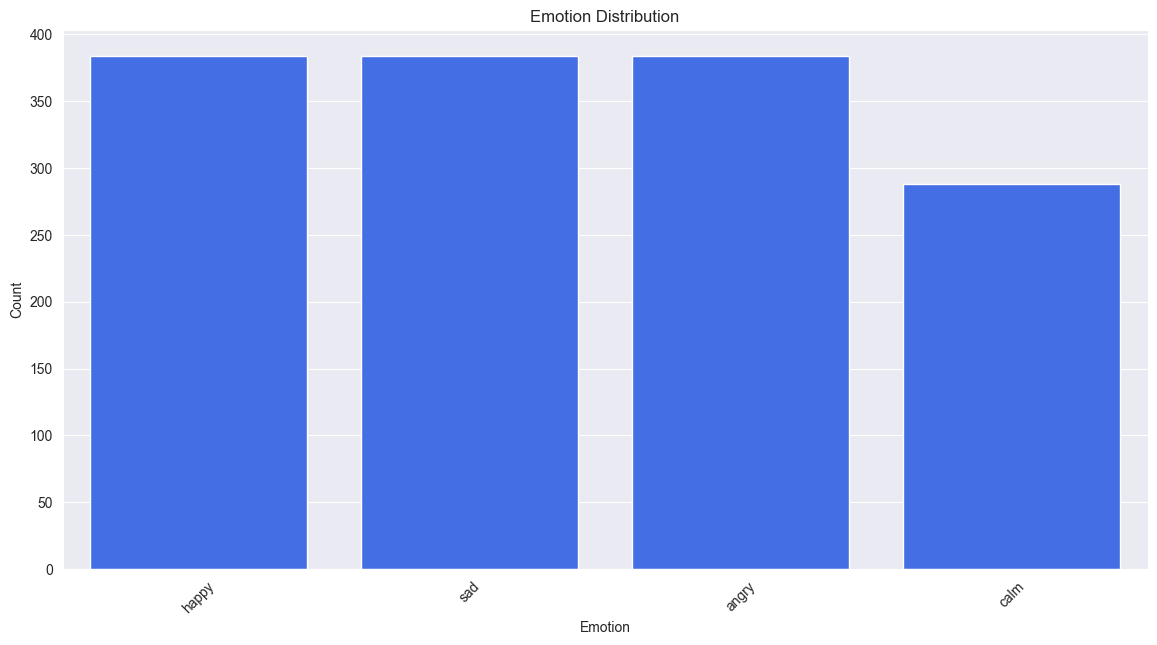

In [24]:
a = data_df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

# V. Data Splitting

In [25]:
# Female Data Set

## Uncomment all below to use Female set

# data2_df = data_df.copy()
# data2_df = data2_df[data2_df.label != "male_none"]
# data2_df = data2_df[data2_df.label != "female_none"]
# data2_df = data2_df[data2_df.label != "male_happy"]
# data2_df = data2_df[data2_df.label != "male_angry"]
# data2_df = data2_df[data2_df.label != "male_sad"]
# data2_df = data2_df[data2_df.label != "male_fearful"]
# data2_df = data2_df[data2_df.label != "male_calm"]
# data2_df = data2_df[data2_df.label != "male_positive"]
# data2_df = data2_df[data2_df.label != "male_negative"].reset_index(drop=True)

# tmp1 = data2_df[data2_df.actor == 22]
# tmp2 = data2_df[data2_df.actor == 24]
# data3_df = pd.concat([tmp1, tmp2],ignore_index=True).reset_index(drop=True)
# data2_df = data2_df[data2_df.actor != 22]
# data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
# print (len(data2_df))
# data2_df.head()

In [26]:
# Male Data Set

## Uncomment all below to use Male set

data2_df = data_df.copy()
# data2_df = data2_df[data2_df.label != "male_none"]
# data2_df = data2_df[data2_df.label != "female_none"].reset_index(drop=True)
# data2_df = data2_df[data2_df.label != "female_neutral"]
# data2_df = data2_df[data2_df.label != "female_happy"]
# data2_df = data2_df[data2_df.label != "female_angry"]
# data2_df = data2_df[data2_df.label != "female_sad"]
# data2_df = data2_df[data2_df.label != "female_fearful"]
# data2_df = data2_df[data2_df.label != "female_calm"]
# data2_df = data2_df[data2_df.label != "female_positive"]
# data2_df = data2_df[data2_df.label != "female_negative"].reset_index(drop=True)
# 

tmp1 = data2_df[data2_df.actor == 21]
tmp2 = data2_df[data2_df.actor == 22]
tmp3 = data2_df[data2_df.actor == 23]
tmp4 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp2, tmp3, tmp4],ignore_index=True).reset_index(drop=True)
# data2_df = data2_df[data2_df.actor != 21]
# data2_df = data2_df[data2_df.actor != 22]
# data2_df = data2_df[data2_df.actor != 23].reset_index(drop=True)
# data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
# print (len(data2_df))
# data2_df.head()

In [27]:
print (len(data3_df))
data3_df.head()

240


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,./data/Actor_21/03-01-01-01-01-01-21.wav,1,21,male,0,0,0,1,calm
1,./data/Actor_21/03-01-01-01-01-02-21.wav,1,21,male,0,0,1,1,calm
2,./data/Actor_21/03-01-01-01-02-01-21.wav,1,21,male,0,1,0,1,calm
3,./data/Actor_21/03-01-01-01-02-02-21.wav,1,21,male,0,1,1,1,calm
4,./data/Actor_21/03-01-02-01-01-01-21.wav,1,21,male,0,0,0,2,calm


# VI. Getting the features of audio files using librosa

In [28]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data_df))):
    X, sample_rate = librosa.load(data_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|██████████| 1440/1440 [00:41<00:00, 34.31it/s]


In [29]:
data.head()

,feature
0,"[-65.801285, -65.801285, -65.801285, -65.80128..."
1,"[-63.190998, -62.800423, -63.831062, -60.55308..."
2,"[-65.81898, -65.81898, -65.81898, -65.81898, -..."
3,"[-66.058586, -66.058586, -66.058586, -66.05858..."
4,"[-70.26808, -70.26808, -70.26808, -70.26808, -..."


In [30]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data_df.label

In [31]:
df3.head(10)

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-63.190998,-62.800423,-63.831062,-60.553082,-60.822178,-62.073860,-64.889618,-65.390274,-65.390274,-65.390274,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-65.818977,-65.818977,-65.818977,-65.818977,-65.805702,-65.818977,-65.818977,-65.629707,-64.802902,-65.818977,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-66.058586,-66.058586,-66.058586,-66.058586,-66.058586,-66.058586,-66.058586,-66.058586,-66.058586,-66.058586,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-70.268082,-70.268082,-69.958099,-68.378006,-69.862946,-70.268082,-70.122566,-68.555412,-70.206917,-70.268082
5,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-65.240265,-65.536674,-67.557671,-67.557671,...,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.127472,-67.557671
6,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.620888,-69.693359,-68.906807,...,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.383789,-69.693359,-69.693359,-69.693359,-69.693359
7,-69.051476,-69.051476,-69.051476,-69.051476,-69.051476,-68.755074,-69.051476,-69.051476,-69.051476,-68.359322,...,-65.447311,-68.552307,-69.051476,-69.051476,-69.051476,-68.688873,-69.051476,NaN,NaN,NaN
8,-73.841858,-73.841858,-73.841858,-73.720078,-73.841858,-73.841858,-73.841858,-73.304192,-72.807358,-73.841858,...,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858
9,-69.243607,-69.243607,-69.243607,-69.243607,-68.902374,-67.983444,-68.089653,-67.897789,-65.258499,-67.171410,...,-58.846359,-57.186440,-61.189224,-67.108902,-67.508621,-66.246048,-68.733475,-69.243607,-69.243607,-69.243607


In [32]:
newdf = pd.concat([df3,labels], axis=1)

In [33]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

1440

In [34]:
rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,calm
1,-63.190998,-62.800423,-63.831062,-60.553082,-60.822178,-62.073860,-64.889618,-65.390274,-65.390274,-65.390274,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,calm
2,-65.818977,-65.818977,-65.818977,-65.818977,-65.805702,-65.818977,-65.818977,-65.629707,-64.802902,-65.818977,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,calm
3,-66.058586,-66.058586,-66.058586,-66.058586,-66.058586,-66.058586,-66.058586,-66.058586,-66.058586,-66.058586,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,calm
4,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-70.268082,-69.958099,-68.378006,-69.862946,-70.268082,-70.122566,-68.555412,-70.206917,-70.268082,calm
5,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-65.240265,-65.536674,-67.557671,-67.557671,...,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.127472,-67.557671,calm
6,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.620888,-69.693359,-68.906807,...,-69.693359,-69.693359,-69.693359,-69.693359,-69.383789,-69.693359,-69.693359,-69.693359,-69.693359,calm
7,-69.051476,-69.051476,-69.051476,-69.051476,-69.051476,-68.755074,-69.051476,-69.051476,-69.051476,-68.359322,...,-68.552307,-69.051476,-69.051476,-69.051476,-68.688873,-69.051476,NaN,NaN,NaN,calm
8,-73.841858,-73.841858,-73.841858,-73.720078,-73.841858,-73.841858,-73.841858,-73.304192,-72.807358,-73.841858,...,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,calm
9,-69.243607,-69.243607,-69.243607,-69.243607,-68.902374,-67.983444,-68.089653,-67.897789,-65.258499,-67.171410,...,-57.186440,-61.189224,-67.108902,-67.508621,-66.246048,-68.733475,-69.243607,-69.243607,-69.243607,calm


In [35]:
rnewdf.isnull().sum().sum()

5708

In [36]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,calm
1,-63.190998,-62.800423,-63.831062,-60.553082,-60.822178,-62.073860,-64.889618,-65.390274,-65.390274,-65.390274,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,calm
2,-65.818977,-65.818977,-65.818977,-65.818977,-65.805702,-65.818977,-65.818977,-65.629707,-64.802902,-65.818977,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,calm
3,-66.058586,-66.058586,-66.058586,-66.058586,-66.058586,-66.058586,-66.058586,-66.058586,-66.058586,-66.058586,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,calm
4,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-70.268082,-69.958099,-68.378006,-69.862946,-70.268082,-70.122566,-68.555412,-70.206917,-70.268082,calm


# VII. Data Augmentation

In [37]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data

def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)

def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data

def pitch(data, sample_rate):
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change = pitch_pm * 2*(np.random.uniform())

    # Corrected usage of pitch_shift
    data = librosa.effects.pitch_shift(data.astype('float64'),
                                       sr=sample_rate,
                                       n_steps=pitch_change,
                                       bins_per_octave=bins_per_octave)
    return data

def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)

def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data




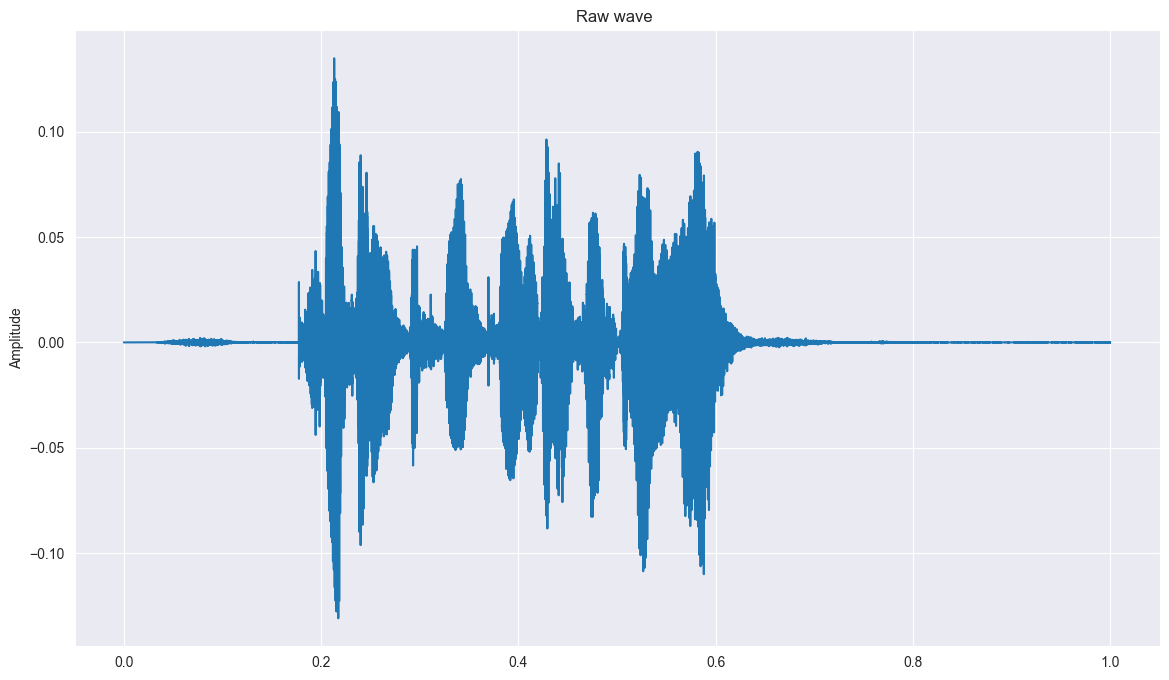

In [38]:
X, sample_rate = librosa.load(data_df.path[216], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.5)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

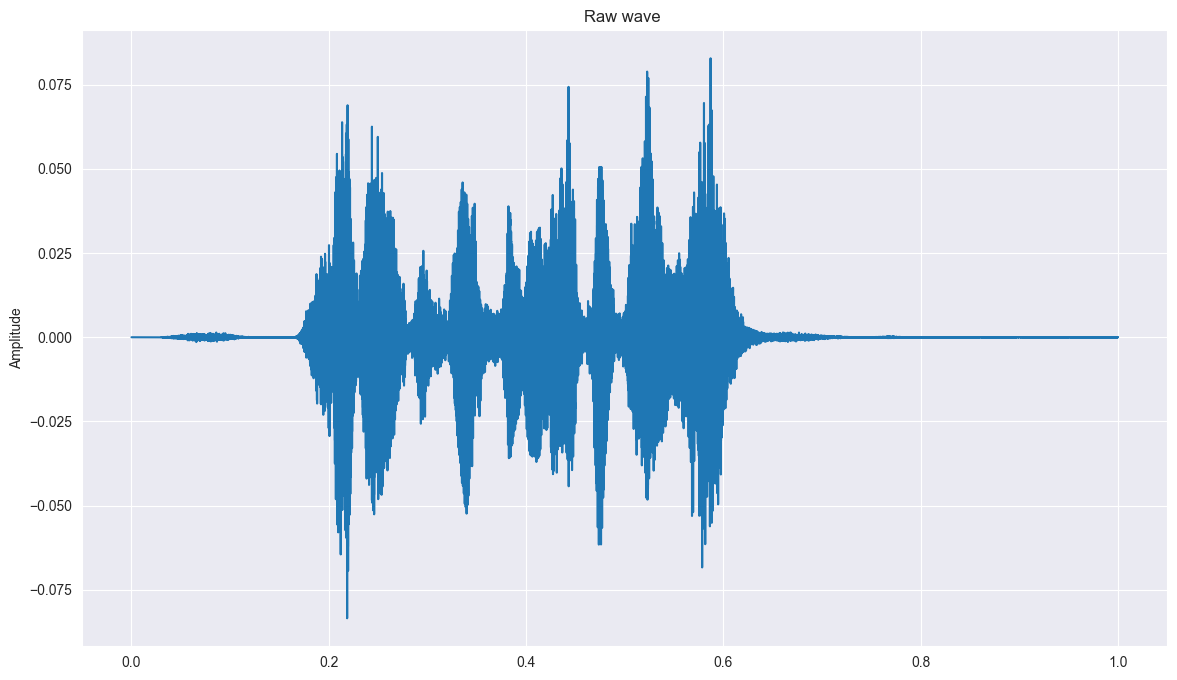

In [39]:
x = pitch(X, sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

In [40]:
# Augmentation Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data_df))):
    X, sample_rate = librosa.load(data_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data_df.label[i]]


100%|██████████| 1440/1440 [00:46<00:00, 31.24it/s]


In [41]:
# Augmentation Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data_df))):
    X, sample_rate = librosa.load(data_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data_df.label[i]]


100%|██████████| 1440/1440 [01:59<00:00, 12.10it/s]


In [42]:
len(syn_data1), len(syn_data2)

(1440, 1440)

In [43]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [44]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

1440

In [45]:
syndf1.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-62.344737,-60.714124,-61.810319,-62.516846,-61.258131,-62.996279,-63.598657,-61.841147,-60.316660,-60.778668,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,calm
1,-53.857968,-52.469146,-51.774948,-51.080953,-53.178158,-55.507488,-54.941294,-54.835769,-52.476701,-50.870783,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,calm
2,-50.060730,-47.983229,-51.559224,-51.342312,-51.626607,-51.367129,-50.340584,-48.969441,-49.304012,-49.631696,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,calm
3,-65.373565,-63.996264,-62.264278,-60.056433,-62.131727,-62.303059,-62.161977,-63.286530,-64.185922,-63.603326,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,calm
4,-70.247383,-69.998641,-69.931222,-70.126896,-70.143057,-69.769945,-70.107714,-70.002023,-70.178927,-70.279977,...,-70.221516,-69.002088,-68.24183,-68.831171,-68.818429,-68.333783,-66.50016,-68.677212,-70.154376,calm


In [46]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

1440

In [47]:
syndf2.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-68.531907,-68.531907,-68.531907,-68.531907,-68.531907,-68.531907,-68.531907,-68.531907,-68.531907,-68.531907,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,calm
1,-63.875030,-63.983152,-64.003167,-62.674448,-64.844386,-66.877692,-67.996764,-68.305776,-68.305776,-68.305776,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,calm
2,-67.779000,-67.779000,-67.779000,-67.779000,-67.575578,-67.779000,-67.779000,-66.980541,-67.157790,-67.779000,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,calm
3,-65.467142,-65.467142,-65.467142,-65.467142,-65.467142,-65.467142,-65.467142,-65.467142,-65.467142,-65.467142,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,calm
4,-70.755782,-70.755782,-70.755782,-70.755782,-70.755782,-70.755782,-70.755782,-70.755782,-70.755782,-70.755782,...,-70.755782,-70.216391,-68.84551,-70.435514,-70.74312,-70.187686,-69.156221,-70.750549,-70.755782,calm


In [48]:
# Combining the Augmented data with original
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()
len(combined_df)

4320

In [49]:
#  Stratified Shuffle Split
from sklearn.model_selection import StratifiedShuffleSplit
X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [50]:
y_train.value_counts()

angry    922
happy    922
sad      921
calm     691
Name: label, dtype: int64

In [51]:
y_test.value_counts()

sad      231
angry    230
happy    230
calm     173
Name: label, dtype: int64

In [52]:
X_train.isna().sum().sum()

0

In [53]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

In [54]:
y_train

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [55]:
X_train.shape

(3456, 259)

# VIII. Changing dimension for CNN model

In [56]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [57]:
# Set up Keras util functions

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    K.clip(y_true, 0, 1)
    precision = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    recall = K.sum(K.round(K.clip(y_true, 0, 1)))
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr



In [58]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
# Edit according to target class no.
model.add(Dense(4))
model.add(Activation('softmax'))
opt = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.0, nesterov=False)


In [59]:
# Original Model

# model = Sequential()
# model.add(Conv1D(256, 5,padding='same', input_shape=(X_train.shape[1],1)))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.1))
# model.add(MaxPooling1D(pool_size=(8)))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Flatten())
# model.add(Dense(5))
# model.add(Activation('softmax'))
# opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [60]:
# Plotting Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 259, 256)          2304      
                                                                 
 activation (Activation)     (None, 259, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 259, 256)          524544    
                                                                 
 batch_normalization (Batch  (None, 259, 256)          1024      
 Normalization)                                                  
                                                                 
 activation_1 (Activation)   (None, 259, 256)          0         
                                                                 
 dropout (Dropout)           (None, 259, 256)          0         
                                                        

In [61]:
# Compile your model

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', fscore])

In [62]:
print(np.isnan(x_traincnn).any(), np.isinf(x_traincnn).any())


False False


In [63]:
x_traincnn = x_traincnn.astype('float32')
x_testcnn = x_testcnn.astype('float32')


# IX. Removed the whole training part for avoiding unnecessary long epochs list

In [64]:
# Model Training

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('model/my_model_uniform_4.keras', save_best_only=True, monitor='val_loss', mode='min')
cnn_history=model.fit(x_traincnn, y_train, batch_size=16, epochs=700,
                      validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])

Epoch 1/700
216/216 [==============================] - 16s 67ms/step - loss: 1.3611 - accuracy: 0.3223 - fscore: 0.6828 - val_loss: 1.3688 - val_accuracy: 0.3241 - val_fscore: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/700
216/216 [==============================] - 14s 63ms/step - loss: 1.2884 - accuracy: 0.3805 - fscore: 1.4063 - val_loss: 1.3106 - val_accuracy: 0.3912 - val_fscore: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/700
216/216 [==============================] - 14s 63ms/step - loss: 1.2676 - accuracy: 0.3964 - fscore: 1.9170 - val_loss: 1.2756 - val_accuracy: 0.4144 - val_fscore: 0.3796 - lr: 1.0000e-04
Epoch 4/700
216/216 [==============================] - 13s 62ms/step - loss: 1.2467 - accuracy: 0.4245 - fscore: 2.2127 - val_loss: 1.2658 - val_accuracy: 0.4236 - val_fscore: 0.2750 - lr: 1.0000e-04
Epoch 5/700
216/216 [==============================] - 14s 63ms/step - loss: 1.2311 - accuracy: 0.4274 - fscore: 2.2574 - val_loss: 1.2527 - val_accuracy: 0.4456 - val_fscore: 0.4803 - lr: 1.0

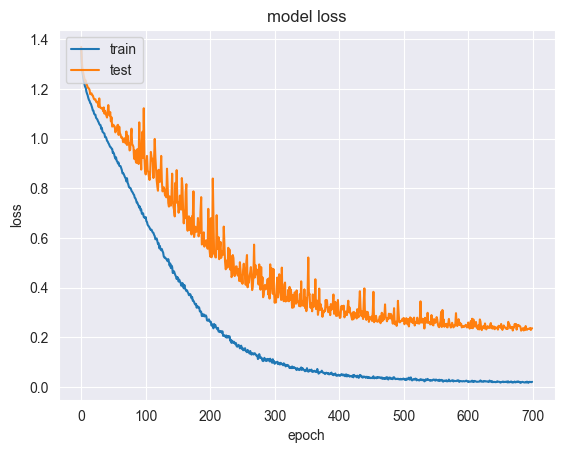

In [66]:
# Plotting the Train Valid Loss Graph

plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [67]:
# Saving the model.json

import json
model_json = model.to_json()
with open("my_model_uniform_4.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [68]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('my_model_uniform_4.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model/my_model_uniform_4.keras")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 92.25%


# X. Predicting emotions on the test data

In [69]:
len(data_df)

1440

In [70]:
data_test = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data3_df))):
    X, sample_rate = librosa.load(data3_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]

test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_lb = np.array(data3_df.label)
lb = LabelEncoder()
test_valid_lb = to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)

100%|██████████| 240/240 [00:06<00:00, 36.62it/s]


In [71]:
preds = loaded_model.predict(test_valid,
                         batch_size=16,
                         verbose=1)

15/15 [==============================] - 0s 18ms/step


In [72]:
preds

array([[4.11018613e-04, 9.94588017e-01, 7.29224412e-04, 4.27179644e-03],
       [3.01003223e-04, 9.98467982e-01, 1.08524560e-04, 1.12240796e-03],
       [5.65536728e-04, 9.97136235e-01, 1.80749875e-03, 4.90630220e-04],
       [3.18887847e-04, 9.99268234e-01, 3.07666254e-04, 1.05236584e-04],
       [8.73727142e-04, 9.98103380e-01, 4.74131375e-05, 9.75479896e-04],
       [2.44511437e-04, 9.98053074e-01, 1.20679685e-03, 4.95700107e-04],
       [2.07513258e-05, 9.98747945e-01, 3.37654317e-04, 8.93704302e-04],
       [5.19951755e-05, 9.97547567e-01, 3.75867239e-05, 2.36292696e-03],
       [2.10342207e-03, 9.96158957e-01, 7.88156874e-04, 9.49462410e-04],
       [6.28591166e-04, 9.98085618e-01, 3.36044672e-04, 9.49865964e-04],
       [6.37069752e-04, 9.94362235e-01, 3.20638437e-03, 1.79427909e-03],
       [2.35495274e-03, 9.97081816e-01, 4.38308198e-04, 1.24976214e-04],
       [5.46320225e-05, 1.96012994e-03, 9.97914135e-01, 7.10899403e-05],
       [2.27522757e-03, 1.18292635e-02, 9.85115945e

In [73]:
preds1=preds.argmax(axis=1)

In [74]:
preds1

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 2, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 0, 2, 2, 2, 2, 2, 0, 3, 3, 3, 3, 3, 3, 3, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 2, 3, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3,
       3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2],
      dtype=int64)

In [75]:
abc = preds1.astype(int).flatten()

In [76]:
predictions = (lb.inverse_transform((abc)))

In [77]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,calm
1,calm
2,calm
3,calm
4,calm
5,calm
6,calm
7,calm
8,calm
9,calm


In [78]:
actual=test_valid_lb.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [79]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,calm
1,calm
2,calm
3,calm
4,calm
5,calm
6,calm
7,calm
8,calm
9,calm


In [80]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [81]:
finaldf[20:40]

,actualvalues,predictedvalues
20,sad,sad
21,sad,sad
22,sad,sad
23,sad,sad
24,sad,sad
25,sad,sad
26,sad,sad
27,sad,sad
28,angry,angry
29,angry,angry


In [82]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
angry,64
calm,48
happy,64
sad,64


In [83]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
angry,95
calm,47
happy,40
sad,58


In [84]:
finaldf.to_csv('Predictions.csv', index=False)

In [85]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix.
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.

    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [87]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

85.83333333333333

In [88]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

86.4469682170164

In [89]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

array([[64,  0,  0,  0],
       [ 1, 46,  0,  1],
       [25,  0, 39,  0],
       [ 5,  1,  1, 57]], dtype=int64)

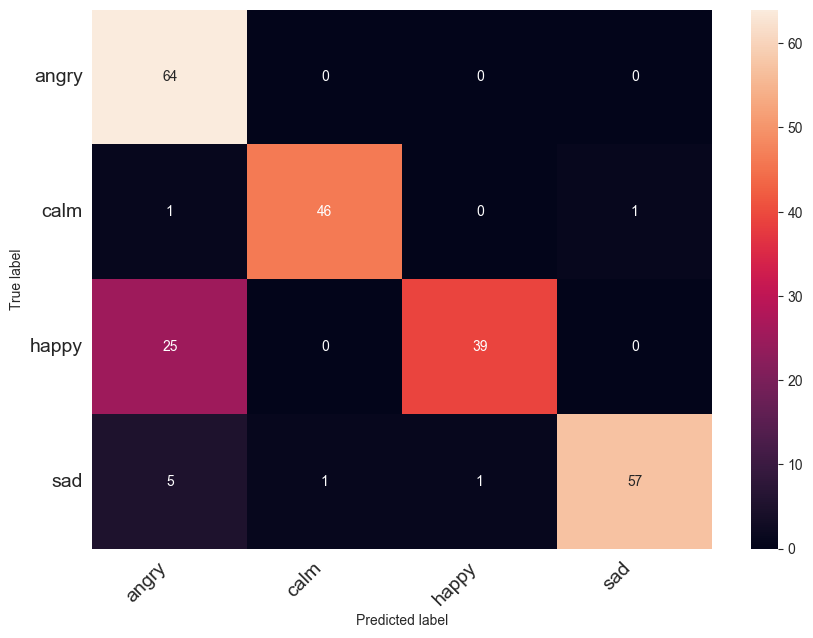

In [90]:
# Visualize Confusion Matrix

# class_names = ['male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']
class_names = ['angry', 'calm', 'happy', 'sad']
# class_names = ['male_negative', 'male_neutral', 'male_positive']
# class_names = ['male_negative', 'male_positive']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad', 'male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']


print_confusion_matrix(c, class_names)